# Image Recognition Demo

## Step 1: Initialise GPU

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# If GPU is available, the print will show 'cuda'. Otherwise it will show 'cpu'
print(device)

cuda


## Step 2: Prepare dataset

In [2]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True, #for training
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4, #process only 4 images at a time
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False, #not for training
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4, #process only 4 images at a time
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Step 3: Visualise some training images

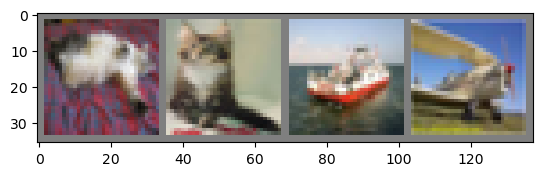

  cat   cat  ship plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print true labels of the images
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Step 4: Define the network architecture

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## Step 5: Set the training parameters and optimizer

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(net.parameters(), lr=0.0005) #lr: learning rate

## Step 6: Train the network

epoch: 1, baches:  2000, loss: 1.871
epoch: 1, baches:  4000, loss: 1.637
epoch: 1, baches:  6000, loss: 1.537
epoch: 1, baches:  8000, loss: 1.450
epoch: 1, baches: 10000, loss: 1.423
epoch: 1, baches: 12000, loss: 1.396
epoch: 2, baches:  2000, loss: 1.312
epoch: 2, baches:  4000, loss: 1.278
epoch: 2, baches:  6000, loss: 1.270
epoch: 2, baches:  8000, loss: 1.250
epoch: 2, baches: 10000, loss: 1.223
epoch: 2, baches: 12000, loss: 1.225
epoch: 3, baches:  2000, loss: 1.162
epoch: 3, baches:  4000, loss: 1.148
epoch: 3, baches:  6000, loss: 1.150
epoch: 3, baches:  8000, loss: 1.138
epoch: 3, baches: 10000, loss: 1.137
epoch: 3, baches: 12000, loss: 1.096
epoch: 4, baches:  2000, loss: 1.041
epoch: 4, baches:  4000, loss: 1.065
epoch: 4, baches:  6000, loss: 1.079
epoch: 4, baches:  8000, loss: 1.065
epoch: 4, baches: 10000, loss: 1.063
epoch: 4, baches: 12000, loss: 1.057
epoch: 5, baches:  2000, loss: 0.991
epoch: 5, baches:  4000, loss: 1.023
epoch: 5, baches:  6000, loss: 0.989
e

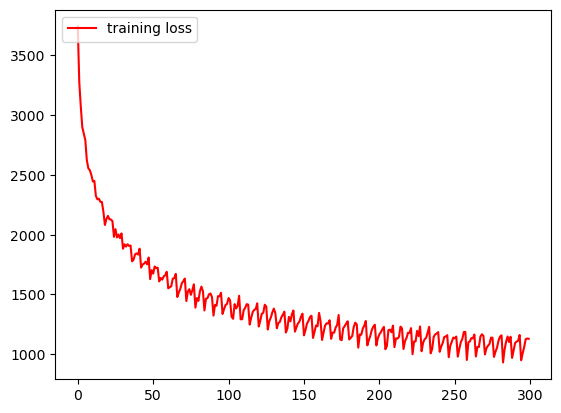

In [6]:
#training
import time
import matplotlib.pyplot as plt

net.to(device)

start_time = time.time()

loss_history = []
epoch = 50
for e in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('epoch: %d, baches: %5d, loss: %.3f' %
                  (e + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss)
            running_loss = 0.0

print('Finished Training')

print('Training time in %s seconds ---' % (time.time() - start_time))

plt.plot(loss_history, label = 'training loss', color = 'r')
plt.legend(loc = 'upper left')
plt.show()

# Save the network after training to file
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

## Step 7: Test the network with some test samples

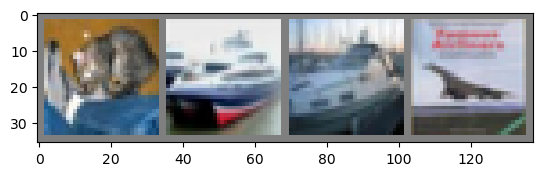

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# show images and print ground-truth labels
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net() #create a network
PATH = './cifar_net.pth'
net.load_state_dict(torch.load(PATH)) #load the trained network
net.to(device)

outputs = net(images.to(device)) #test the network with inputs as images

_, predicted_labels = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted_labels[j]]
                              for j in range(4)))

## Step 8: Evaluate the network on the entire test set

In [8]:
#load the trained network
net = Net()
net.load_state_dict(torch.load(PATH))

#testing
net.to(device)

start_time = time.time()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted_labels = torch.max(outputs.data, 1)
        total += groundtruth_labels.size(0)
        correct += (predicted_labels == groundtruth_labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

print("Testing time is in %s seconds ---" % (time.time() - start_time))

Accuracy of the network on the 10000 test images: 64 %
Testing time is in 9.061660051345825 seconds ---


In [9]:
 
class_correct = list(0. for i in range(10)) 
class_total = list(0. for i in range(10)) 
with torch.no_grad(): 
    for data in testloader: 
        images, groundtruth_labels = data[0].to(device), data[1].to(device) 
        outputs = net(images) 
        _, predicted_labels = torch.max(outputs, 1) 
        c = (predicted_labels == groundtruth_labels).squeeze() 
        for i in range(4): 
            label = groundtruth_labels[i] 
            class_correct[label] += c[i].item() 
            class_total[label] += 1 
 
for i in range(10): 
    print('Accuracy of %5s : %2d %%' % ( 
        classes[i], 100 * class_correct[i] / class_total[i])) 

Accuracy of plane : 63 %
Accuracy of   car : 78 %
Accuracy of  bird : 58 %
Accuracy of   cat : 38 %
Accuracy of  deer : 51 %
Accuracy of   dog : 54 %
Accuracy of  frog : 78 %
Accuracy of horse : 68 %
Accuracy of  ship : 81 %
Accuracy of truck : 73 %


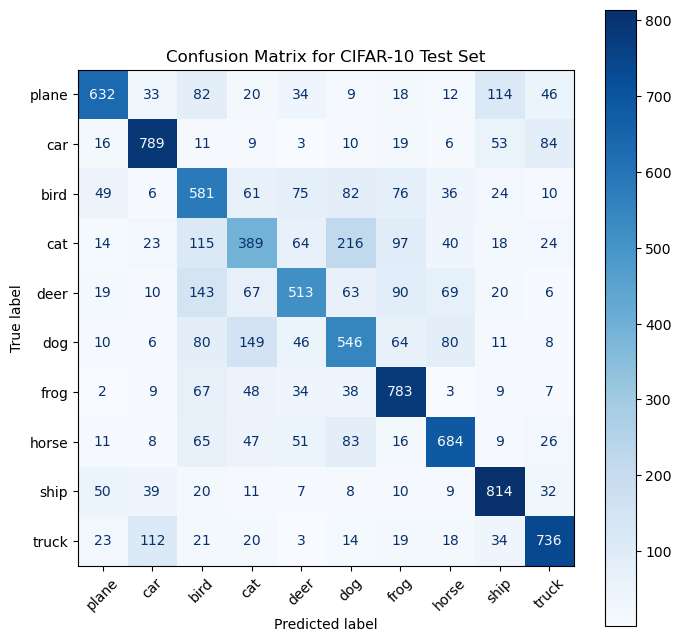

In [ ]:
# Step 9: Calculate and display the confusion matrix for the test set
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_groundtruth = []
all_predicted = []

with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted_labels = torch.max(outputs, 1)
        all_groundtruth.extend(groundtruth_labels.cpu().numpy())
        all_predicted.extend(predicted_labels.cpu().numpy())

cm = confusion_matrix(all_groundtruth, all_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)b
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix for CIFAR-10 Test Set')
plt.show()

In [11]:

from torchvision import datasets 
 
transform = transforms.Compose( 
    [transforms.Resize((32, 32)), #you can change the image size, but need to change  
       #the architecture accordingly 
     transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
 
trainset = datasets.ImageFolder('FoodImages/Train', transform=transform) 
testset = datasets.ImageFolder('FoodImages/Test', transform=transform) 
 
classes = ('Cakes', 'Pasta', 'Pizza') 

## Step 10: Train and evaluate a neural network on the FoodImages dataset
We will use the same architecture as for CIFAR-10, but you are free to experiment with different architectures and learning parameters to maximize performance. The following code will train the model, report the overall accuracy, and display the confusion matrix for the test set.

In [ ]:
# Define trainset, testset, and classes for FoodImages dataset
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_food = datasets.ImageFolder('FoodImages/Train', transform=transform)
testset_food = datasets.ImageFolder('FoodImages/Test', transform=transform)

trainloader_food = torch.utils.data.DataLoader(trainset_food, batch_size=4, shuffle=True, num_workers=2)
testloader_food = torch.utils.data.DataLoader(testset_food, batch_size=4, shuffle=False, num_workers=2)

food_classes = ('Cakes', 'Pasta', 'Pizza')

# Define the network (same as CIFAR-10, but output size = 3)
class FoodNet(nn.Module):
    def __init__(self):
        super(FoodNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

food_net = FoodNet().to(device)

criterion_food = nn.CrossEntropyLoss().to(device)
optimizer_food = optim.AdamW(food_net.parameters(), lr=0.001)

# Train the network
num_epochs = 30
loss_history_food = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader_food, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer_food.zero_grad()
        outputs = food_net(inputs)
        loss = criterion_food(outputs, labels)
        loss.backward()
        optimizer_food.step()
        running_loss += loss.item()
    loss_history_food.append(running_loss)
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.3f}')

print('Finished Training FoodNet')
plt.plot(loss_history_food, label='training loss', color='g')
plt.legend(loc='upper left')
plt.show()

# Evaluate on test set
food_net.eval()
correct = 0
total = 0
all_groundtruth_food = []
all_predicted_food = []
with torch.no_grad():
    for data in testloader_food:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = food_net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_groundtruth_food.extend(labels.cpu().numpy())
        all_predicted_food.extend(predicted.cpu().numpy())

print(f'Accuracy of FoodNet on the test images: {100 * correct / total:.2f} %')

cm_food = confusion_matrix(all_groundtruth_food, all_predicted_food)
disp_food = ConfusionMatrixDisplay(confusion_matrix=cm_food, display_labels=food_classes)
fig, ax = plt.subplots(figsize=(6, 6))
disp_food.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix for FoodImages Test Set')
plt.show()